In [1]:
import pandas as pd
import numpy as np
import shared
import json


In [2]:
ve_or_ju = "ju"

In [3]:
runs_orig = pd.read_csv(f'data/runs_{ve_or_ju}.tsv', delimiter="\t")


In [4]:
country_counts = runs_orig["team_country"].value_counts()
top_country_counts = country_counts[country_counts > 50]
top_countries = top_country_counts.keys().tolist()
display(top_countries)

with open(f"data/top_countries_{ve_or_ju}.json", 'w') as outfile:
    json.dump(top_countries, outfile)

['FIN',
 'SWE',
 'NOR',
 'RUS',
 'LAT',
 'EST',
 'SUI',
 'GBR',
 'LTU',
 'DEN',
 'GER',
 'FRA',
 'ESP',
 'CZE',
 'ITA',
 'POL',
 'USA',
 'UKR',
 'HUN']

In [5]:
runs_orig["first_name"] = runs_orig.name.str.split(" ", expand=True).iloc[:, 0]
runs_df = runs_orig
runs_df.head()

,name,year,team_id,team,team_country,pace,leg_nro,num_runs,first_name
0,joni hirvikallio,2018,2,KOOVEE,FIN,5.873,1,6,joni
1,joni hirvikallio,2017,16,KOOVEE,FIN,5.762,1,6,joni
2,joni hirvikallio,2016,143,KOOVEE,FIN,6.251,6,6,joni
3,joni hirvikallio,2015,12,KOOVEE,FIN,5.843,5,6,joni
4,joni hirvikallio,2013,37,KOOVEE,FIN,5.796,1,6,joni


In [6]:
fn_counts = runs_df["first_name"].value_counts()
top_fn_counts = fn_counts[fn_counts > 20]
top_first_names = top_fn_counts.keys().tolist()
display(top_first_names)

with open(f"data/top_first_names_{ve_or_ju}.json", 'w') as outfile:
    json.dump(top_first_names, outfile)

['mikko',
 'antti',
 'timo',
 'juha',
 'matti',
 'jukka',
 'pekka',
 'mika',
 'jari',
 'jussi',
 'janne',
 'ville',
 'hannu',
 'heikki',
 'kari',
 'markku',
 'petri',
 'sami',
 'tuomas',
 'teemu',
 'marko',
 'harri',
 'lauri',
 'markus',
 'ari',
 'pasi',
 'vesa',
 'olli',
 'jouni',
 'jaakko',
 'eero',
 'arto',
 'tero',
 'juho',
 'tommi',
 'kimmo',
 'jani',
 'jarmo',
 'seppo',
 'risto',
 'tomi',
 'ilkka',
 'esa',
 'jarkko',
 'kalle',
 'tuomo',
 'tapio',
 'jyrki',
 'anders',
 'johan',
 'jorma',
 'simo',
 'erkki',
 'erik',
 'toni',
 'juhani',
 'jouko',
 'petteri',
 'jonas',
 'mikael',
 'joonas',
 'henrik',
 'lasse',
 'pertti',
 'aleksi',
 'martin',
 'henri',
 'jan',
 'aki',
 'samuli',
 'niko',
 'andreas',
 'anssi',
 'juuso',
 'esko',
 'pauli',
 'matias',
 'fredrik',
 'paavo',
 'miika',
 'joni',
 'peter',
 'riku',
 'niklas',
 'anton',
 'tapani',
 'daniel',
 'reijo',
 'martti',
 'kai',
 'jarno',
 'raimo',
 'panu',
 'stefan',
 'thomas',
 'keijo',
 'magnus',
 'per',
 'simon',
 'sakari',
 'pen

In [7]:
# Temporarily remove 2018 in order to try predict it in other notebook
#runs_df = runs_df[runs_df.year != 2018]
#runs_df

In [8]:
features = shared.preprocess_features(runs_df, top_countries, ve_or_ju)
features.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76531 entries, 0 to 76530
Data columns (total 9 columns):
name            76531 non-null object
year            76531 non-null int64
team_id         76531 non-null int64
team            76531 non-null object
team_country    75583 non-null object
pace            76531 non-null float64
leg_nro         76531 non-null int64
num_runs        76531 non-null int64
first_name      76531 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 5.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 3 columns):
first_name           1586 non-null object
fn_pace_class        1587 non-null int64
fn_pace_std_class    1587 non-null int64
dtypes: int64(2), object(1)
memory usage: 37.3+ KB


None

,team_id,team_id_log10,team_id_square,leg_1,leg_2,leg_3,leg_4,leg_5,leg_6,leg_7,...,fn_pace_class_6.0,fn_pace_class_7.0,fn_pace_class_8.0,fn_pace_class_9.0,fn_pace_class_nan,fn_pace_std_class_0.0,fn_pace_std_class_1.0,fn_pace_std_class_2.0,fn_pace_std_class_3.0,fn_pace_std_class_nan
0,2,0.301030,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,16,1.204120,256,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,143,2.155336,20449,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,12,1.079181,144,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,37,1.568202,1369,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,2,0.301030,4,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
6,1,0.000000,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
7,9,0.954243,81,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
8,12,1.079181,144,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
9,21,1.322219,441,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [9]:
features.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 76531 entries, 0 to 76530
Data columns (total 54 columns):
team_id                  76531 non-null Sparse[int64, nan]
team_id_log10            76531 non-null Sparse[float64, nan]
team_id_square           76531 non-null Sparse[int64, nan]
leg_1                    76531 non-null Sparse[uint8, 0]
leg_2                    76531 non-null Sparse[uint8, 0]
leg_3                    76531 non-null Sparse[uint8, 0]
leg_4                    76531 non-null Sparse[uint8, 0]
leg_5                    76531 non-null Sparse[uint8, 0]
leg_6                    76531 non-null Sparse[uint8, 0]
leg_7                    76531 non-null Sparse[uint8, 0]
c_CZE                    76531 non-null Sparse[uint8, 0]
c_DEN                    76531 non-null Sparse[uint8, 0]
c_ESP                    76531 non-null Sparse[uint8, 0]
c_EST                    76531 non-null Sparse[uint8, 0]
c_FIN                    76531 non-null Sparse[uint8, 0]
c_FRA          

In [10]:
x = features.values
#x = features[["team_id", "team_id_log10", "team_id_log100", "team_id_log2", "team_id_square", "leg_id_1", "leg_id_2", "leg_id_3", "leg_id_4", "leg_id_5", "leg_id_6", "leg_id_7"]].values # Poista tää.
y = np.log(runs_df.pace.values)
y = y.reshape(len(y), 1)

display(x.shape)
display(y.shape)

(76531, 54)

(76531, 1)

In [11]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2019)
x_train.shape

(61224, 54)

In [13]:
import matplotlib.pyplot as plt
def fit_and_test_model(model, x_train, x_test, y_train, y_test, fit_params={}):
    model.fit(x_train, y_train.ravel(), **fit_params)
    y_pred = np.exp(model.predict(x_test))
    print(f"Shapes: y_test={np.exp(y_test).shape} y_pred={y_pred.shape}")
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))
    
    plt.scatter(x_test[:,0], np.exp(y_test),  color='red', alpha=0.01)
    plt.scatter(x_test[:,0], y_pred, color='blue', alpha=0.01)
    plt.ylim(4, 20)
    plt.show()

In [14]:
y_train.shape

(61224, 1)

Shapes: y_test=(15307, 1) y_pred=(15307,)
Mean squared error: 5.340
Explained variance score: 0.400


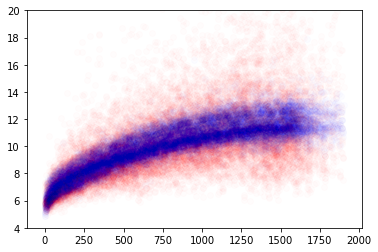

CPU times: user 1.61 s, sys: 437 ms, total: 2.05 s
Wall time: 774 ms


In [15]:
%%time
linear = linear_model.LinearRegression()
fit_and_test_model(linear, x_train, x_test, y_train, y_test)

In [16]:
pd.DataFrame({'name':features.keys(), 'coef':linear.coef_})

,name,coef
0,team_id,4.135214e-04
1,team_id_log10,1.146085e-01
2,team_id_square,-1.382898e-07
3,leg_1,-7.256984e-02
4,leg_2,-2.736896e-02
5,leg_3,-2.152515e-02
6,leg_4,5.672601e-02
7,leg_5,8.120502e-02
8,leg_6,2.524823e-02
9,leg_7,-4.171531e-02


      Iter       Train Loss   Remaining Time 
         1           0.0633           18.15m
         2           0.0587           17.61m
         3           0.0550           17.32m
         4           0.0518           17.36m
         5           0.0492           17.21m
         6           0.0470           17.15m
         7           0.0452           17.28m
         8           0.0437           17.43m
         9           0.0424           17.58m
        10           0.0414           17.59m
        20           0.0365           17.69m
        30           0.0348           17.07m
        40           0.0340           16.67m
        50           0.0336           16.28m
        60           0.0333           15.95m
        70           0.0331           15.67m
        80           0.0330           15.45m
        90           0.0329           15.33m
       100           0.0328           15.29m
       200           0.0322           14.63m
       300           0.0318           14.22m
       40

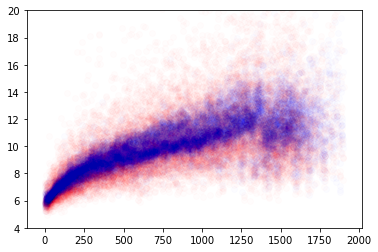

CPU times: user 14min 47s, sys: 1.24 s, total: 14min 48s
Wall time: 14min 49s


In [17]:
%%time
gbr_num_estimators=7100
gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=gbr_num_estimators, random_state=0, verbose=1)

fit_and_test_model(gbr, x_train, x_test, y_train, y_test)

#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))

In [18]:
gbr_num_estimators_quantile=int(gbr_num_estimators/2)

      Iter       Train Loss   Remaining Time 
         1           0.0570            8.14m
         2           0.0546            8.25m
         3           0.0525            8.18m
         4           0.0507            8.19m
         5           0.0493            8.09m
         6           0.0479            8.09m
         7           0.0468            8.13m
         8           0.0459            8.13m
         9           0.0450            8.14m
        10           0.0444            8.14m
        20           0.0413            8.07m
        30           0.0401            8.21m
        40           0.0396            8.19m
        50           0.0394            8.08m
        60           0.0392            7.97m
        70           0.0391            7.88m
        80           0.0390            7.78m
        90           0.0390            7.71m
       100           0.0389            7.65m
       200           0.0386            7.18m
       300           0.0384            6.92m
       40

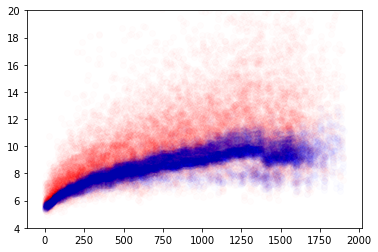

In [19]:
gbr_q_low = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.159, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
fit_and_test_model(gbr_q_low, x_train, x_test, y_train, y_test)


      Iter       Train Loss   Remaining Time 
         1           0.0647           10.41m
         2           0.0625           10.39m
         3           0.0607           10.19m
         4           0.0592           10.12m
         5           0.0577           10.00m
         6           0.0565            9.94m
         7           0.0554            9.90m
         8           0.0545            9.85m
         9           0.0537            9.84m
        10           0.0530            9.81m
        20           0.0490            9.49m
        30           0.0475            9.25m
        40           0.0467            9.09m
        50           0.0463            9.01m
        60           0.0460            8.88m
        70           0.0459            8.74m
        80           0.0457            8.66m
        90           0.0457            8.58m
       100           0.0456            8.53m
       200           0.0451            7.88m
       300           0.0449            7.48m
       40

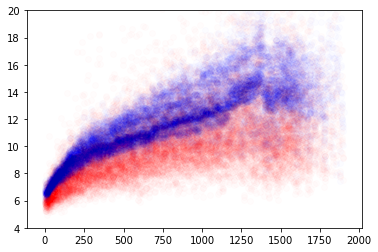

In [20]:
gbr_q_high = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.841, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
fit_and_test_model(gbr_q_high, x_train, x_test, y_train, y_test)



In [21]:
joblib.dump(gbr, 'gbr.sav')
joblib.dump(gbr_q_low, 'gbr_q_low.sav')
joblib.dump(gbr_q_high, 'gbr_q_high.sav')


['gbr_q_high.sav']

In [22]:
gbr_preds = gbr.predict(pd.DataFrame(x_test))
gbr_q_low_preds = gbr_q_low.predict(pd.DataFrame(x_test))
gbr_q_high_preds = gbr_q_high.predict(pd.DataFrame(x_test))

In [23]:
gbr_q_pred_errors = pd.DataFrame({
    'q_low':np.exp(gbr_q_low_preds),
    'true':np.exp(y_test).ravel(), 
    'predicted':np.exp(gbr_preds), 
    'q_high':np.exp(gbr_q_high_preds), 
})

gbr_q_pred_errors["q_low_error"] = gbr_q_pred_errors.true < gbr_q_pred_errors.q_low
gbr_q_pred_errors["q_high_error"] = gbr_q_pred_errors.true > gbr_q_pred_errors.q_high
gbr_q_pred_errors["q_error"] = np.logical_or(gbr_q_pred_errors.q_low_error, gbr_q_pred_errors.q_high_error)

# Intentionally don't use log scale for calculation to get bigger std 
gbr_q_pred_errors["std"] = (gbr_q_pred_errors.q_high - gbr_q_pred_errors.q_low) / 2
gbr_q_pred_errors["std_correct"] = np.exp((gbr_q_high_preds - gbr_q_low_preds) / 2)
gbr_q_pred_errors["abs_error"] = np.abs(gbr_q_pred_errors.predicted - gbr_q_pred_errors.true)
gbr_q_pred_errors["abs_error_in_stds"] = gbr_q_pred_errors.abs_error / np.exp(gbr_q_pred_errors["std_correct"])

display(gbr_q_pred_errors.tail(15).round(3))
display(gbr_q_pred_errors.q_low_error.mean())
display(gbr_q_pred_errors.q_high_error.mean())
display(gbr_q_pred_errors.q_error.mean())
display(gbr_q_pred_errors["std"].mean())
display(gbr_q_pred_errors["std_correct"].mean())
display(gbr_q_pred_errors["abs_error_in_stds"].mean())

,q_low,true,predicted,q_high,q_low_error,q_high_error,q_error,std,std_correct,abs_error,abs_error_in_stds
15292,10.384,17.575,13.081,16.719,False,True,True,3.167,1.269,4.494,1.263
15293,8.719,10.949,10.000,11.768,False,False,False,1.524,1.162,0.949,0.297
15294,6.314,6.672,6.854,7.737,False,False,False,0.711,1.107,0.182,0.060
15295,10.525,13.673,13.948,18.689,False,False,False,4.082,1.333,0.275,0.072
15296,7.426,8.632,8.802,10.347,False,False,False,1.461,1.180,0.170,0.052
15297,8.044,8.447,9.129,10.527,False,False,False,1.241,1.144,0.682,0.217
15298,5.672,7.385,6.261,7.185,False,True,True,0.757,1.126,1.124,0.365
15299,9.377,8.509,10.966,13.084,True,False,True,1.853,1.181,2.457,0.754
15300,8.550,12.159,9.864,11.486,False,True,True,1.468,1.159,2.295,0.720
15301,7.804,12.132,10.669,11.919,False,True,True,2.058,1.236,1.463,0.425


0.15966551251061606

0.1632586398379826

0.32292415234859867

1.7813903324110156

1.1834981517667447

0.44951568217190135

In [24]:
np.exp(1.138)

3.1205210778255728

In [25]:
%%date

UsageError: Cell magic `%%date` not found.


In [ ]:
STOP_HERE

In [ ]:
import os
#os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'
#os.environ['THEANO_FLAGS'] = 'device=cuda,floatX=float32,force_device=True'

import pymc3 as pm
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))


In [ ]:
import multiprocessing
multiprocessing.cpu_count()

In [ ]:

pmlearn_linear = LinearRegression()
fit_params={
    "inference_type": "nuts",
    "inference_args": {
        "cores": multiprocessing.cpu_count() -1,
        #"chains":2,
        "init": 'adapt_diag',
        #"tune": 2000,
        "target_accept": 0.9999
    }
}
fit_and_test_model(pmlearn_linear, pd.DataFrame(data=x_train), pd.DataFrame(x_test), y_train, y_test,fit_params)

In [ ]:
pmlearn_preds = pmlearn_linear.predict(pd.DataFrame(x_test), return_std=True)

In [ ]:

joblib.dump(pmlearn_linear, 'pmlearn_linear.sav')

In [ ]:
pred_errors = pd.DataFrame({
    'mean':np.exp(pmlearn_preds[0]), 
    'std':np.exp(pmlearn_preds[1]), 
    'true':np.exp(y_test).ravel(), 
    'error':np.abs(np.exp(y_test).ravel() -np.exp(pmlearn_preds[0])) / np.exp(pmlearn_preds[1])
})
display(pred_errors.head(15))
pred_errors.error.mean()

In [ ]:
pmlearn_linear.plot_elbo()

In [ ]:
pm.traceplot(pmlearn_linear.trace)

In [ ]:
pm.forestplot(pmlearn_linear.trace, varnames=["betas", "alpha", "s"]);

In [ ]:
summary_df = pm.summary(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])
summary_df

In [ ]:
pm.plot_posterior(pmlearn_linear.trace, varnames=["betas", "alpha", "s"],
                 figsize = [14, 8])

In [ ]:
pm.gelman_rubin(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])